**This notebook has not yet been completed and will be expanded in the future.**

# Imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv
/kaggle/input/health-insurance-cross-sell-prediction/train.csv
/kaggle/input/health-insurance-cross-sell-prediction/test.csv


In [3]:
df = pd.read_csv("../input/health-insurance-cross-sell-prediction/train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# Quick EDA

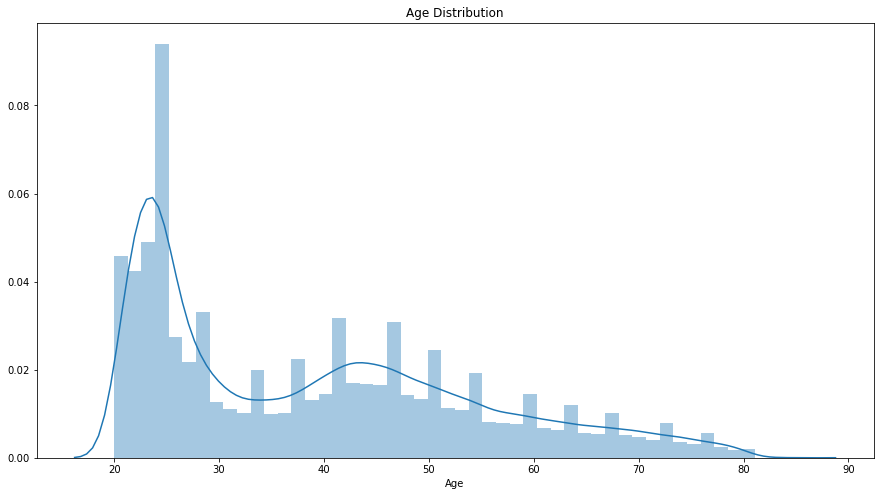

In [55]:
plt.figure(figsize=(15,8))
plt.title("Age Distribution")
sns.distplot(df.Age);

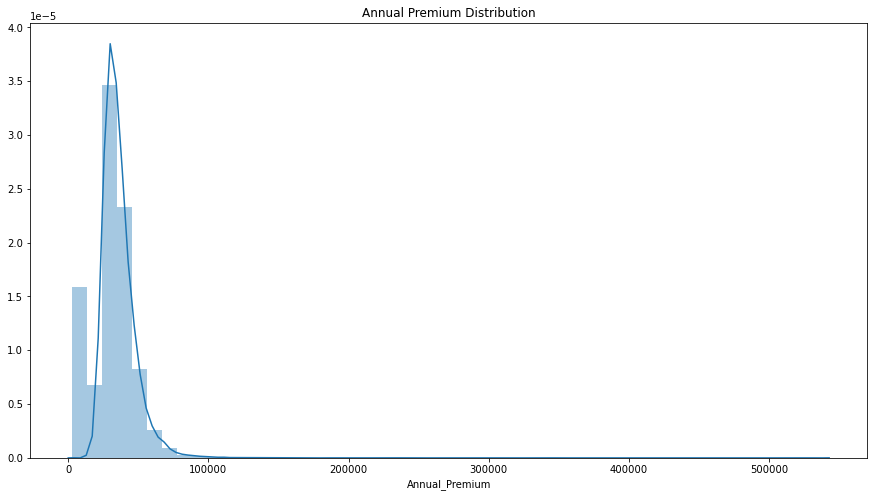

In [7]:
plt.figure(figsize=(15,8))
plt.title("Annual Premium Distribution")
sns.distplot(df.Annual_Premium);

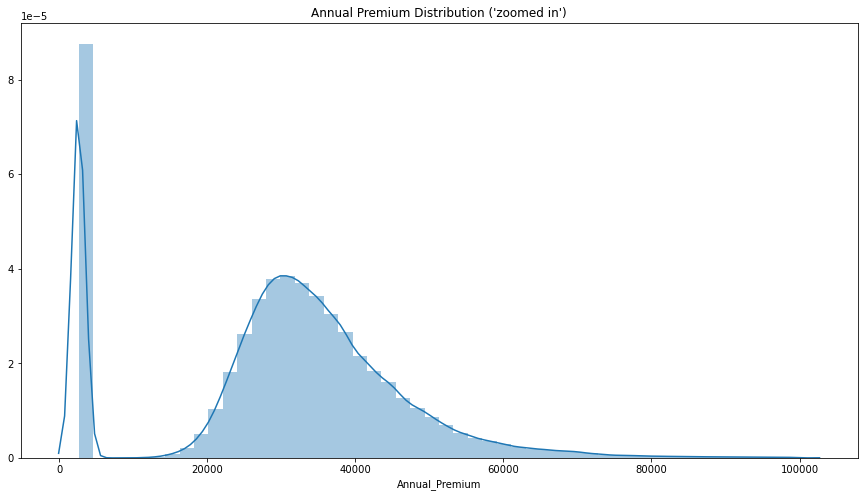

In [8]:
plt.figure(figsize=(15,8))
plt.title("Annual Premium Distribution ('zoomed in')")
sns.distplot(df.query("Annual_Premium < 100000").Annual_Premium);

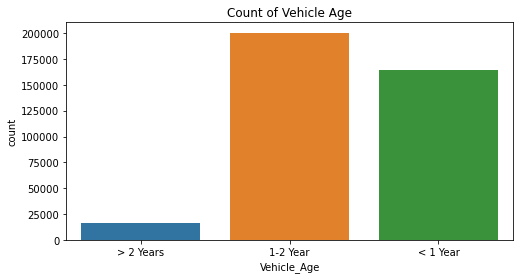

In [9]:
plt.figure(figsize=(8,4))
plt.title("Count of Vehicle Age")
sns.countplot(df.Vehicle_Age);

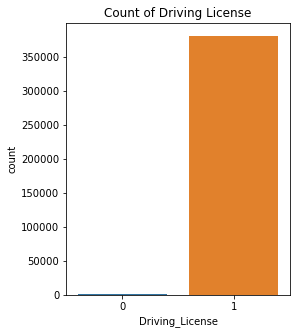

In [53]:
plt.figure(figsize=(4,5))
plt.title("Count of Driving License")
sns.countplot(df.Driving_License);

In [11]:
# Exact numbers of Driving License
df.Driving_License.value_counts()

1    380297
0       812
Name: Driving_License, dtype: int64

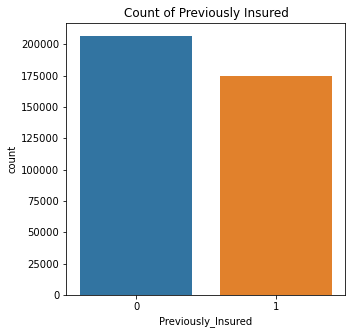

In [12]:
plt.figure(figsize=(5,5))
plt.title("Count of Previously Insured")
sns.countplot(df.Previously_Insured);

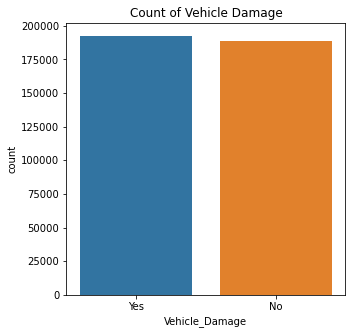

In [13]:
plt.figure(figsize=(5,5))
plt.title("Count of Vehicle Damage")
sns.countplot(df.Vehicle_Damage);

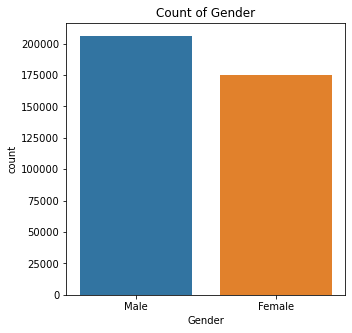

In [14]:
plt.figure(figsize=(5,5))
plt.title("Count of Gender")
sns.countplot(df.Gender);

In the next step I will have a closer look to our target label/variable "Response", because this is our value that we want to predict.

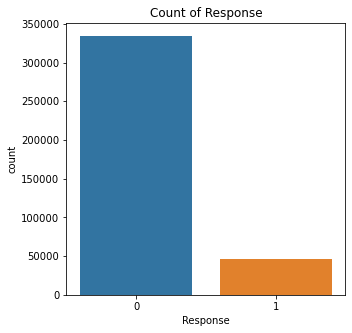

In [15]:
plt.figure(figsize=(5,5))
plt.title("Count of Response")
sns.countplot(df.Response);

In [17]:
print("{}% answered positively".format(round((df.Response.value_counts()[1]/df.Response.value_counts()[0])*100,2)))

13.97% answered positively


We can see that the data is very unbalanced. I think we can use stratify, cross-validation or up-/downsampling for this problem. I will cover this in later steps. 

More information: 
* https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification 
* https://towardsdatascience.com/handling-imbalanced-data-4fb691e23fe9

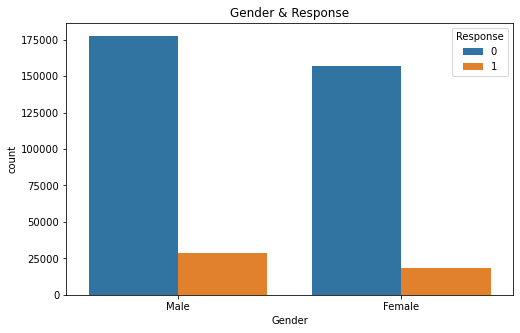

In [32]:
# Gender & Response
plt.figure(figsize=(8,5))
plt.title("Gender & Response")
sns.countplot(df["Gender"], hue=df["Response"]);

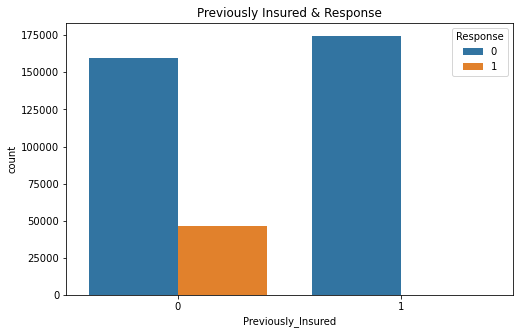

In [44]:
# Gender & Response
plt.figure(figsize=(8,5))
plt.title("Previously Insured & Response")
sns.countplot(df["Previously_Insured"], hue=df["Response"]);

In [48]:
# Looks like there is no positive response for customers who were previously insured 
df.query("Response == 1")["Previously_Insured"].value_counts()

0    46552
1      158
Name: Previously_Insured, dtype: int64

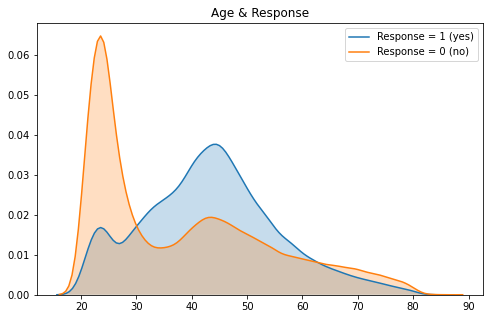

In [107]:
# Age & Response
plt.figure(figsize=(8,5))
plt.title("Age & Response")
sns.kdeplot(df.query("Response == 1")["Age"], label="Response = 1 (yes)", shade=True)
sns.kdeplot(df.query("Response == 0")["Age"], label="Response = 0 (no)", shade=True)
plt.legend();

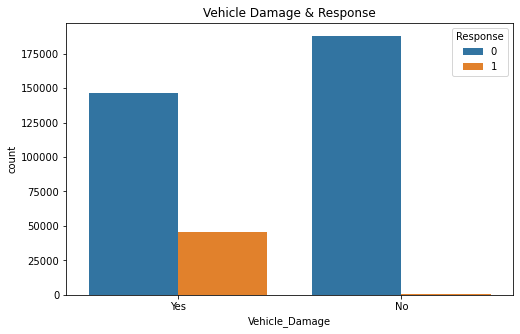

In [51]:
# Vehicle Damage & Response
plt.figure(figsize=(8,5))
plt.title("Vehicle Damage & Response")
sns.countplot(df["Vehicle_Damage"], hue=df["Response"]);

In [50]:
# Vehicle Age & Response
va_resp = df.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
va_resp

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


In [ ]:
# Visualization


In [69]:
# Policy Sales Channel & Response
df["Policy_Sales_Channel"].value_counts().describe()

count       155.000000
mean       2458.767742
std       13928.481161
min           1.000000
25%           8.500000
50%          51.000000
75%         243.000000
max      134784.000000
Name: Policy_Sales_Channel, dtype: float64

In [84]:
# Closer look at the top 25% of Policy Sales Channels
psc_resp = df.groupby(['Policy_Sales_Channel'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
psc_resp = psc_resp[psc_resp["count"] >= 243]
psc_resp.head()

,Policy_Sales_Channel,count
0,1.0,1074
2,3.0,523
3,4.0,509
5,7.0,1598
6,8.0,1515


In [93]:
psc_resp = df.groupby(['Policy_Sales_Channel']).Age.agg([len, min, np.mean, max])
psc_resp.head()

,len,min,mean,max
Policy_Sales_Channel,,,,
1.0,1074,20,40.447858,80
2.0,4,44,50.250000,57
3.0,523,32,57.902486,80
4.0,509,31,48.510806,80
6.0,3,28,38.666667,53


In [96]:
# Closer look at the top 25% of Policy Sales Channels
psc_resp = psc_resp[psc_resp["len"] >= 243]
psc_resp.shape

(39, 4)

In [100]:
# Still to much so I will take the Top 10%
df["Policy_Sales_Channel"].value_counts().quantile(q=0.9)

1251.9999999999998

In [101]:
psc_resp = psc_resp[psc_resp["len"] >= 1252]
psc_resp.shape

(16, 4)

In [102]:
psc_resp

,len,min,mean,max
Policy_Sales_Channel,,,,
7.0,1598,26,54.520651,85
8.0,1515,26,53.416502,82
13.0,1865,25,53.902949,84
25.0,1848,36,54.884199,81
26.0,79700,20,50.683413,85
30.0,1410,25,56.600000,82
55.0,1264,27,52.994462,80
122.0,9930,20,51.920544,85
124.0,73995,20,46.923589,85


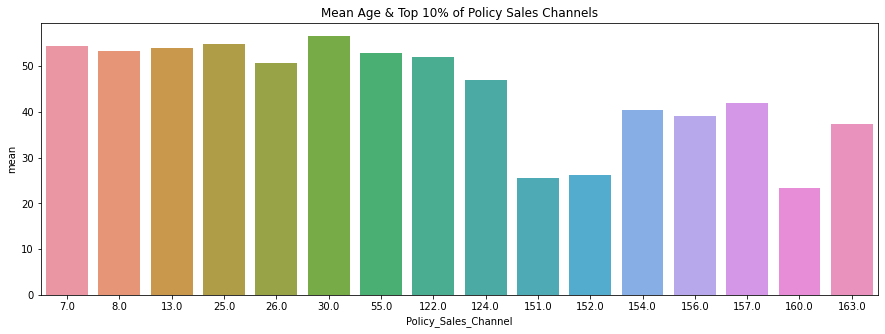

In [103]:
# Visualization 
plt.figure(figsize=(15,5))
plt.title("Mean Age & Top 10% of Policy Sales Channels")
sns.barplot(x=psc_resp.index, y=psc_resp["mean"]);

We can see that across the different Policy Sales Channels there are big differences in terms of average age. Currently, I don't know what exactly the different numbers on the Policy Sales Channel mean. 

### Heatmap & Correlations

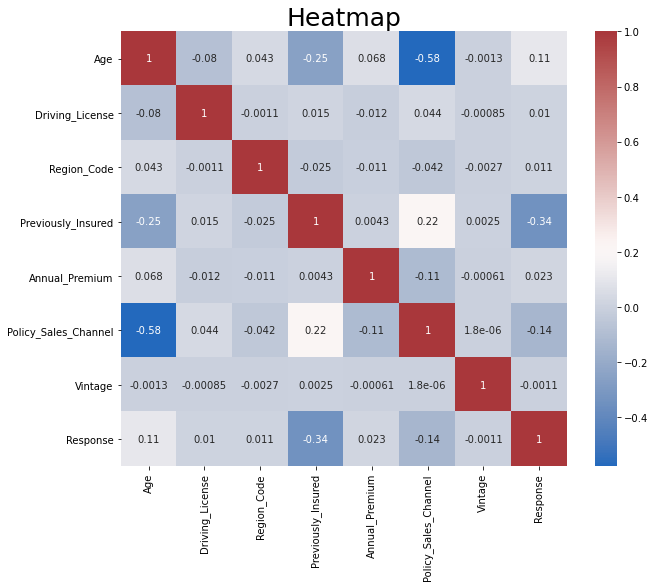

In [21]:
df_corr = df.drop("id", axis=1)

plt.figure(figsize=(10,8))
plt.title("Heatmap", fontsize=25)
sns.heatmap(df_corr.corr(),annot=True,cmap="vlag");

### Pairplot / Scatter Matrix

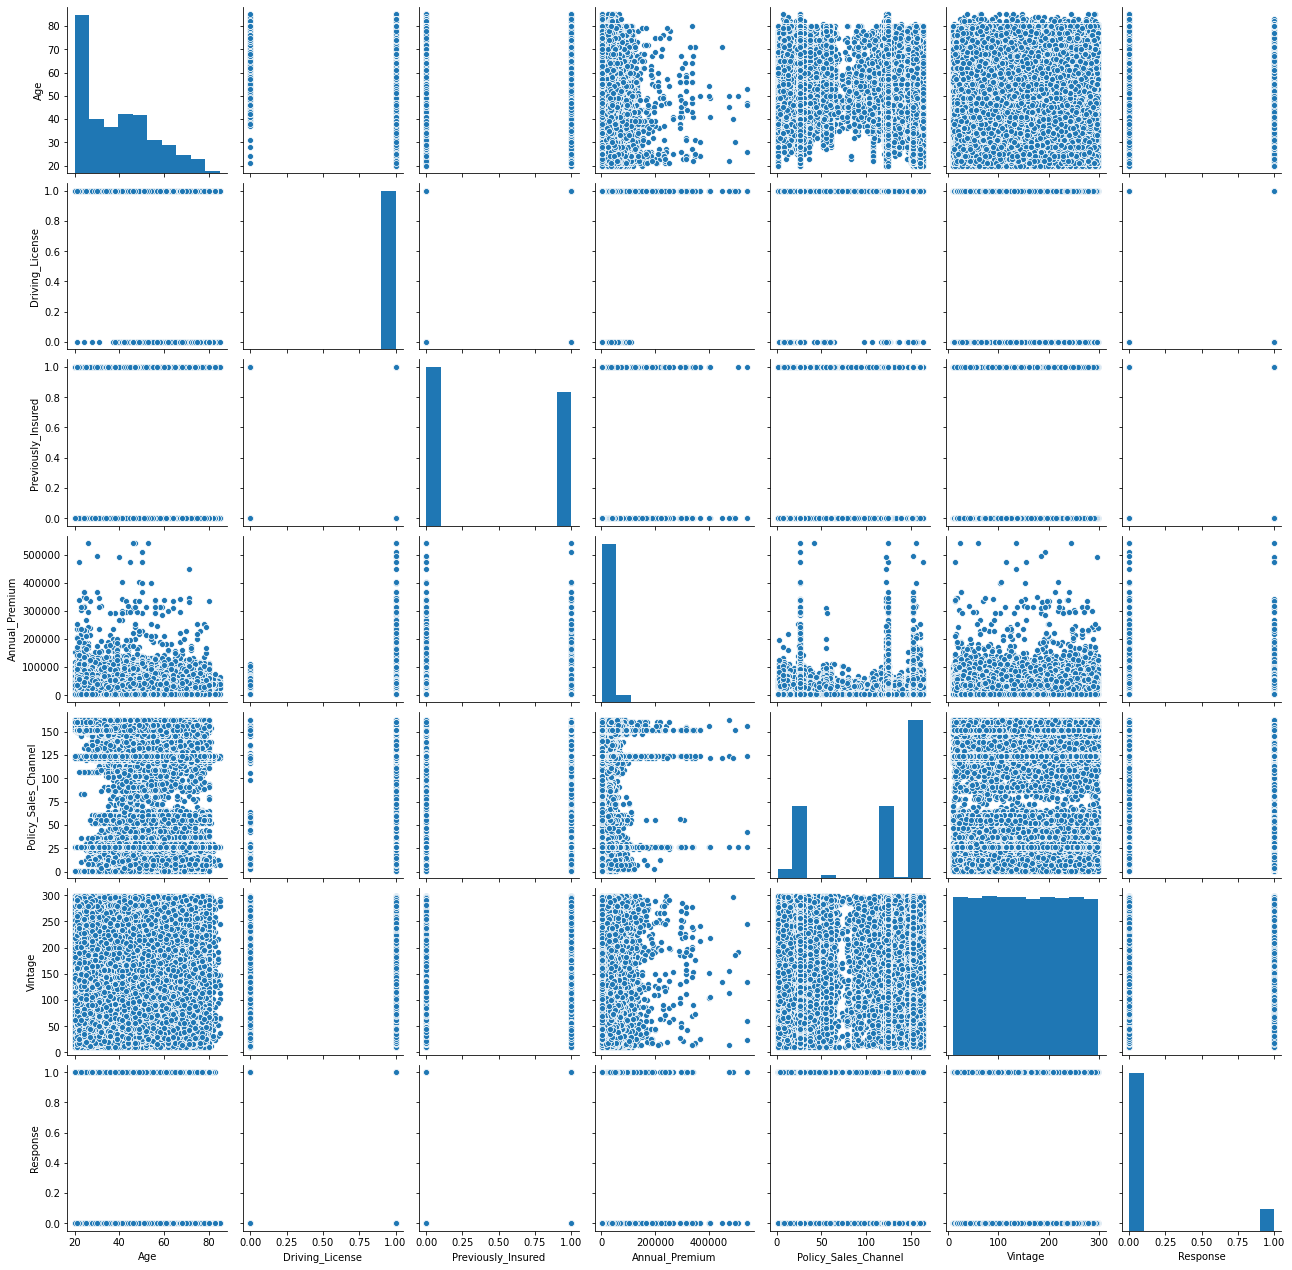

In [26]:
sns.pairplot(df.drop(["id","Region_Code"], axis=1));

# Data Preprocessing

# Modeling

## Clustering (unsupervised Learning)

## Baseline Model

# Feature Importance

# Evaluation